In [2]:
### Stock Volatility Prediction using Histroical Data ####
### Predict whether tomorrow's high is higher or lower than today's high
### using historical stock price
import numpy as np
import pandas as pd
import csv
import inds_functions as ids
import MySQLdb as mdb
import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import Quandl
import datetime as dt

%pylab inline

apikey = 'hjKhd2KM3o6FGDCsdXxK'
line_w = 2.5
fsize = 16
styles_line = ['-b','-r','-g','-c','-k', '--b','--r','--g','--c','--k']

Populating the interactive namespace from numpy and matplotlib


In [4]:
start_date = "2005-1-1"
end_date = "2015-10-31"
stk_name = "WIKI/AMZN"
index_name = "NASDAQOMX/COMP"

total training data size: (2714, 17)
Out of Bag Performance: 0.67

which means the expected accuracy for a new dataset
 Features                Importances
 0  : 1st Day open       0.08
 7  : 1st Day n_low      0.08
 2  : 1st Day low        0.03
 9  : 2nd Day high       0.03
 13 : 2nd Day n_index    0.03
 8  : 2nd Day open       0.03
 1  : 1st Day high       0.03
 33 : 2nd Day high       0.03
 12 : 2nd Day volume     0.03
 15 : 2nd Day n_low      0.03
 30 : 2nd Day n_high     0.03
 14 : 2nd Day n_high     0.03
 16 : 2nd Day open       0.03
 11 : 2nd Day close      0.03
 28 : 2nd Day volume     0.03
 21 : 2nd Day n_index    0.03
 4  : 1st Day volume     0.03
 29 : 2nd Day n_index    0.03
 31 : 2nd Day n_low      0.03
 24 : 2nd Day open       0.03
 32 : 2nd Day open       0.03
 10 : 2nd Day low        0.03
 3  : 1st Day close      0.03
 17 : 2nd Day high       0.03
 27 : 2nd Day close      0.03
 20 : 2nd Day volume     0.03
 19 : 2nd Day close      0.03
 25 : 2nd Day high       0.03
 26 

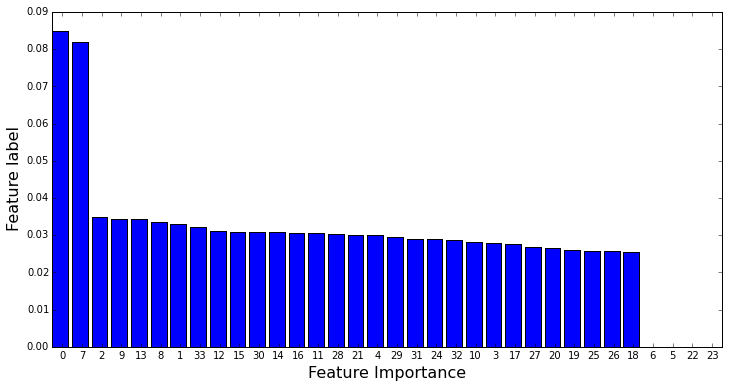

In [5]:
stk_nm = "WIKI/AMZN"
stk = Quandl.get(stk_nm, authtoken=apikey,trim_start=start_date, trim_end=end_date)
nsd = Quandl.get(index_name, authtoken=apikey,trim_start=start_date, trim_end=end_date)
data = pd.concat([stk, nsd], axis=1, join='inner')
data = data.sort_index(ascending=True)
data = np.array(data)
print "total training data size:", data.shape
'''
print list(mydata.columns)
start = mydata.index.searchsorted(dt.datetime(2013, 1, 2))
end = mydata.index.searchsorted(dt.datetime(2013, 1, 4))
print [start, end]
mydata.ix[start:end]
#mydata
'''
#data1 = np.array(stk.iloc[:, -5:])
#data2 = np.array(nsd.iloc[:,:3])
#data = np.concatenate((data1, data2), axis=1)
header = ['open','high','low', 'close', 'volume', 'n_index', 'n_high', 'n_low']

### Data Processing ###
data_diff = data[:-1,:] - data[1:,:]
### Predition Setup ###
# target
lag = 3
y = np.array(data_diff[:-lag,1]>0, dtype=int)
X = ids.GetX(data_diff, lag=lag)
X = X[:y.shape[0],:]
#X = ids.Data_Rescale(X)

### Random Forest ###
clf = RandomForestClassifier(n_estimators=400, criterion ='gini' , \
      max_depth=None, oob_score=True)
clf.fit(X, y)
oob = clf.oob_score_
feature_importance = clf.feature_importances_
index = np.argsort(feature_importance)[::-1]
feature_importance = np.sort(feature_importance)[::-1]

### Results output ###
print "Out of Bag Performance: %.2f\n" % oob
print "which means the expected accuracy for a new dataset"
#print "Feature Importances: \n", clf.feature_importances_

print " Features                Importances"
for i in range(len(feature_importance)):
    if index[i] < len(header):
        feature = "1st Day " + header[index[i]]
    else:
        feature = "2nd Day " + header[index[i]%len(header)]
    print " %-2d : %-16s   %.2f" % (index[i], feature, clf.feature_importances_[index[i]])    
plt.figure(3, figsize = (12, 6))
plt.bar(np.arange(len(index)), feature_importance)
plt.xticks(np.arange(len(index))+0.5, index)
plt.xlim([0, len(index)])
plt.xlabel("Feature Importance", fontsize = fsize)
plt.ylabel("Feature label", fontsize = fsize)

###################  GOOG  ##################
Correlation Matrix of original data:
         open     high     low      close    volume   
open       1      0.9999   0.9998   0.9997   -0.4965  
high     0.9999     1      0.9998   0.9999   -0.4938  
low      0.9998   0.9998     1      0.9999   -0.5016  
close    0.9997   0.9999   0.9999     1      -0.4977  
volume   -0.4965  -0.4938  -0.5016  -0.4977    1      




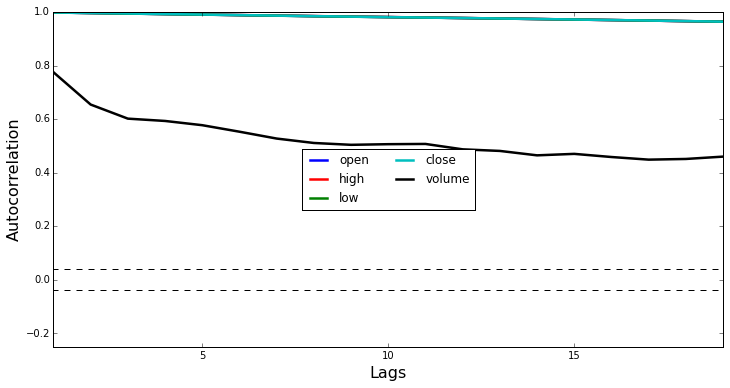

In [53]:
### Preprocessing data ###
data = np.asarray(data, dtype=float)
np.set_printoptions(precision=2)

# Auro-correlation 
xlims = [1, 20-1]
ylims = [-0.25, 1]

CF95 = np.ones((data.shape[0], 2))*1.96/np.sqrt(data.shape[0])
CF95[:,1] = -CF95[:,1]
plt.figure(1, figsize = (12, 6))
for i in range(data.shape[1]):
    plt.plot(ids.Autocor(data[:,i], 20),styles_line[i%len(styles_line)], linewidth = line_w, label = header[i])
plt.plot(CF95[:,0], '--k', linewidth = 1.0)
plt.plot(CF95[:,1], '--k', linewidth = 1.0)
plt.ylabel("Autocorrelation", fontsize = fsize)
plt.xlabel("Lags", fontsize = fsize)
plt.legend(loc = "center", ncol=2)
plt.xlim(xlims)
plt.ylim(ylims)
#plt.show()

# Cross correlation
Cor_Mat= np.corrcoef(data, rowvar = 0)
print "###################  GOOG  ##################"
print "Correlation Matrix of original data:\n",
ids.Print_Cor_Mat(Cor_Mat, header)

###################  GOOG  ##################
Correlation Matrix of original data:
         open     high     low      close    volume   
open       1      0.7521   0.7108   0.3487   -0.0503  
high     0.7521     1      0.7299   0.7098   0.0588   
low      0.7108   0.7299     1      0.7073   -0.2304  
close    0.3487   0.7098   0.7073     1      -0.0814  
volume   -0.0503  0.0588   -0.2304  -0.0814    1      




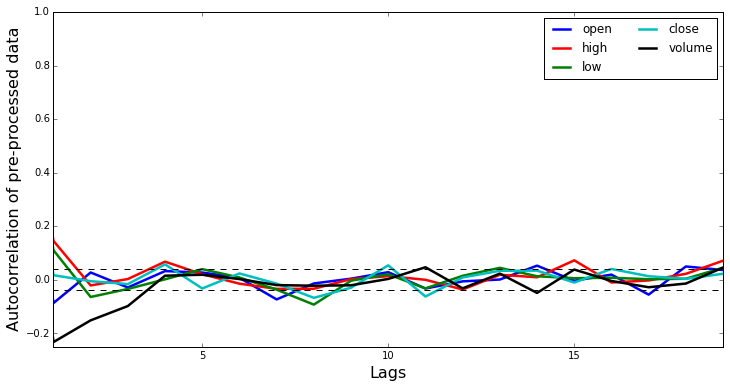

In [61]:
### Data Processing ###
data_diff = data[:-1,:] - data[1:,:]

# Auro-correlation 
xlims = [1, 20-1]
ylims = [-0.25, 1]
CF95 = np.ones((data_diff.shape[0], 2))*1.96/np.sqrt(data_diff.shape[0])
CF95[:,1] = -CF95[:,1]
plt.figure(2, figsize = (12, 6))
for i in range(data_diff.shape[1]):
    plt.plot(ids.Autocor(data_diff[:,i], 20),styles_line[i%len(styles_line)], linewidth = line_w, label = header[i])
plt.plot(CF95[:,0], '--k', linewidth = 1.0)
plt.plot(CF95[:,1], '--k', linewidth = 1.0)
plt.ylabel("Autocorrelation of pre-processed data", fontsize = fsize)
plt.xlabel("Lags", fontsize = fsize)
plt.legend(loc = "upper right", ncol=2)
plt.xlim(xlims)
plt.ylim(ylims)
#plt.show()

# Cross correlation
Cor_Mat= np.corrcoef(data_diff, rowvar = 0)
print "###################  GOOG  ##################"
print "Correlation Matrix of original data:\n",
ids.Print_Cor_Mat(Cor_Mat, header)

Out of Bag Performance: 0.69

which means the expected accuracy for a new dataset
 Features                Importances
 3  : 1st Day close      0.22
 2  : 1st Day low        0.11
 1  : 1st Day high       0.10
 0  : 1st Day open       0.09
 4  : 1st Day volume     0.08
 8  : 2nd Day close      0.08
 9  : 2nd Day volume     0.08
 7  : 2nd Day low        0.08
 6  : 2nd Day high       0.08
 5  : 2nd Day open       0.08


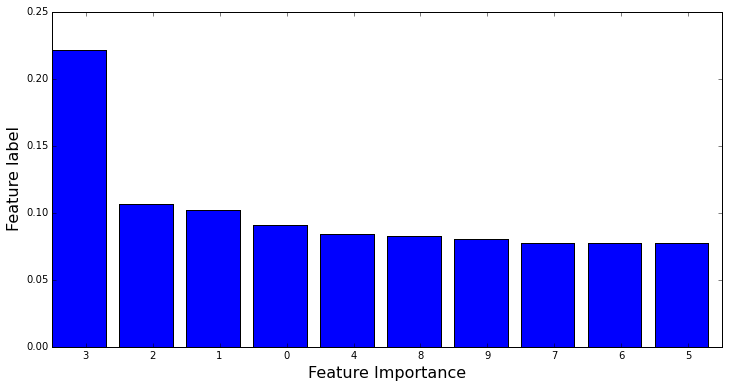

In [73]:
data = data[::-1, :] 
### Data Processing ###
data_diff = data[:-1,:] - data[1:,:]
### Predition Setup ###
# target
lag = 3
y = np.array(data_diff[:-lag,1]>0, dtype=int)
X = ids.GetX(data_diff, lag=lag)
X = X[:y.shape[0],:]
#X = ids.Data_Rescale(X)

### Random Forest ###
clf = RandomForestClassifier(n_estimators=400, criterion ='gini' , \
      max_depth=None, oob_score=True)
clf.fit(X, y)
oob = clf.oob_score_
feature_importance = clf.feature_importances_
index = np.argsort(feature_importance)[::-1]
feature_importance = np.sort(feature_importance)[::-1]

### Results output ###
print "Out of Bag Performance: %.2f\n" % oob
print "which means the expected accuracy for a new dataset"
#print "Feature Importances: \n", clf.feature_importances_

print " Features                Importances"
for i in range(len(feature_importance)):
    if index[i] < len(header):
        feature = "1st Day " + header[index[i]]
    else:
        feature = "2nd Day " + header[index[i]%len(header)]
    print " %-2d : %-16s   %.2f" % (index[i], feature, clf.feature_importances_[index[i]])    
plt.figure(3, figsize = (12, 6))
plt.bar(np.arange(len(index)), feature_importance)
plt.xticks(np.arange(len(index))+0.5, index)
plt.xlim([0, len(index)])
plt.xlabel("Feature Importance", fontsize = fsize)
plt.ylabel("Feature label", fontsize = fsize)